# Demo:  Document Clustering and Latent Semantic Analysis

An important application of clustering is for sorting documents into groups.  In this demo, we will illustrate how to use the k-means algorithms for this task.  This example is taken mostly from one of the [sklearn examples](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html).

Through the demo, you will learn how to:
* Represent a corpus as a set of strings
* Build a vocabulary from a corpus
* Compute the TF-IDF scores for the documents in the corpus based on the vocabulary
* Run k-means to automatically discover document clusters
* Display key terms in each document cluster
* Perform an LSA on a corpus with a sparse SVD.

## Loading the Data

First, we load the standard packages along with a number of `sklearn` sub-packages for text processing.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import sys
from time import time

import numpy as np

The [UseNet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup) were popular 20 years ago as online forums for discussing various issues.  Although they are not used much today for topic discussions, the posts from that era are still widely-used in machine learning classes for demonstrating various text processing methods.  Due to their wide use, the `sklearn` package has a built-in routine `fetch_20newsgroups` for extracting the newsgroup examples.  We will extract just four of the 20 categories in this demo.

In [2]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


We use the `np.unique` command to compute the number of unique labels.

In [3]:
labels = dataset.target
true_k = len(np.unique(labels))

The data is in the `data` field of `dataset`.  Each entry `dataset.data[i]` is a string corresponding to the post to the newsgroup.  We can print an example as follows.

In [4]:
doc_ind = 10  # Index of an example document
data_ex = dataset.data[doc_ind]
cat_ex  = dataset.target_names[labels[doc_ind]]
print('Post from {0:s}'.format(cat_ex))
print()
print(data_ex)

Post from comp.graphics

From: richter@fossi.hab-weimar.de (Axel Richter)
Subject: True Color Display in POV
Keywords: POV, Raytracing
Nntp-Posting-Host: fossi.hab-weimar.de
Organization: Hochschule fuer Architektur und Bauwesen Weimar, Germany
Lines: 6


Hallo POV-Renderers !
I've got a BocaX3 Card. Now I try to get POV displaying True Colors
while rendering. I've tried most of the options and UNIVESA-Driver
but what happens isn't correct.
Can anybody help me ?



## Computing TF-IDF features

Documents are natively text.  To apply most machine learning algorithms, we need to convert the documents to vectors.  One popular method is the so-called TF-IDF score.  First, we select a set of words in the corpus.  Each word is sometimes called a *token*.  For each token `n` and document `i`, we then compute the data matrix:
      
    X[n,i] = TF-IDF score of word i in document n
           = term freq[n,i] * inverse doc frequency[i]
           
where

    term freq[n,i]  = (#occurances of word i in doc n)/(#words in doc n)  
    inverse doc freq[i] = log(#docs in corpus/#docs with word i)
        
In the data matrix `X`, each document `n` is represented by a vector `X[n,:]`.

The data matrix `X` can be computed by a *vectorizer*.  Writing an efficient vectorizer is somewhat time-consuming.  Luckily, `sklearn` has very good routines to compute the TF-IDF representations of a corpus.  We first create a `TfidfVectorizer` object:

In [5]:
vectorizer = TfidfVectorizer( 
                max_df=0.5, # max doc freq (as a fraction) of any word to include in the vocabulary
                min_df=2,   # min doc freq (as doc counts) of any word to include in the vocabulary
                max_features=10000,           # max number of words in the vocabulary
                stop_words='english',         # remove English stopwords
                use_idf=True )        # use IDF scores

Then, we create the data matrix from the dataset.

In [6]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
X = vectorizer.fit_transform(dataset.data)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
done in 1.329500s
n_samples: 3387, n_features: 10000


We can display the terms with the highest TF-IDF scores in a post as follows.

In [7]:
doc_ind = 10  # Index of an example document
xi = X[doc_ind,:].todense()
term_ind = xi.argsort()[:, ::-1]
xi_sort = xi[0,term_ind]
terms = vectorizer.get_feature_names()

for i in range(30):
    term = terms[term_ind[0,i]]
    tfidf = xi[0,term_ind[0,i]]
    print('{0:20s} {1:f} '.format(term, tfidf))

weimar               0.565396 
pov                  0.518174 
renderers            0.183033 
univesa              0.178595 
und                  0.174842 
fuer                 0.171591 
true                 0.159214 
raytracing           0.150534 
displaying           0.140240 
ve                   0.139752 
options              0.134309 
rendering            0.133027 
driver               0.129544 
happens              0.122540 
colors               0.119138 
card                 0.113776 
display              0.108457 
germany              0.108231 
tried                0.106282 
color                0.103717 
anybody              0.100397 
correct              0.100234 
isn                  0.084694 
got                  0.081865 
keywords             0.081865 
try                  0.080601 
help                 0.078058 
nntp                 0.044277 
host                 0.043985 
posting              0.042608 


## Run k-Means

We now run k-means on the TF-IDF vectors to try  to automatically detect clusters.  First, we construct a `kMeans` object to perform the clustering.

In [8]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

Then, we run the k-means clustering.  This will run through several iterations.

In [10]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)
Initialization complete
Iteration  0, inertia 6471.584
Iteration  1, inertia 3298.955
Iteration  2, inertia 3286.116
Iteration  3, inertia 3282.101
Iteration  4, inertia 3280.273
Iteration  5, inertia 3279.445
Iteration  6, inertia 3278.835
Iteration  7, inertia 3278.143
Iteration  8, inertia 3277.275
Iteration  9, inertia 3276.412
Iteration 10, inertia 3275.771
Iteration 11, inertia 3275.325
Iteration 12, inertia 3274.769
Iteration 13, inertia 3274.301
Iteration 14, inertia 3274.040
Iteration 15, inertia 3273.789
Iteration 16, inertia 3273.598
Iteration 17, inertia 3273.358
Iteration 18, inertia 3273.018
Iteration 19, inertia 3272.584
Iteration 20, inertia 3272.387
Iteration 21, inertia 3272.262
Iteration 22, inertia 3272.163
Iteration 23, inertia 3272.137
Iteration 24, iner

To get an idea of the clusters, we print out the terms corresponding to the 10 largest components of the centroid in each cluster.  You can clearly see the clustering of topics.

In [11]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: graphics image thanks university files file 3d help gif ac
Cluster 1: space com nasa article gov university posting like just host
Cluster 2: god com sandvik people keith jesus say don morality sgi
Cluster 3: henry access toronto digex pat alaska zoo spencer net space


## Comparison of clusters to newsgroup categories

The clusters found by k-means were not based on the newsgroup category in which the post came from.  To compare the two, we create a sort of confusion matrix where:

`C[i,j] = ` fraction of cluster `j` came from newsgroup `i`.

In [12]:
labelkm = km.labels_
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels,labelkm)

Csum = np.sum(C,axis=0)
Cnorm = C / Csum[None,:]
print(Cnorm)

[[ 0.00469484  0.11244378  0.66358025  0.        ]
 [ 0.94131455  0.12668666  0.00102881  0.00436681]
 [ 0.03521127  0.54947526  0.          0.97816594]
 [ 0.01877934  0.2113943   0.33539095  0.01746725]]


To interpret this confusion matrix, let's print out the newsgroup names:

In [13]:
dataset.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Now, returning to the confusion matrix, we see that some discovered clusters lie almost entirely within one of the newsgroup subjects.  This is especially true for `comp.graphics` and `sci.space`.  However, some discovered clusters tend to have entries of both `alt.atheism` and `talk.religon.misc`, whose topics are likely to have a lot of overlap.

We print an example of a post that came from a newsgroup that is different from the most common newsgroup in that cluster.

In [14]:
I = np.where((labels==3) & (labelkm == 3))[0]
doc_ind = I[3]
ind_cluster = labelkm[doc_ind]
km_cat = dataset.target_names[np.argmax(Cnorm[:,ind_cluster])]

data_ex = dataset.data[doc_ind]
true_cat  = dataset.target_names[labels[doc_ind]]
print('Actual newsgroup: {0:s}'.format(true_cat))
print('Most common newsgroup in cluster:  {0:s}'.format(km_cat))
print()
print(data_ex)

Actual newsgroup: talk.religion.misc
Most common newsgroup in cluster:  sci.space

From: dickeney@access.digex.com (Dick Eney)
Subject: Re: Swastika (was: Hitler - pagan or Christian?)
Organization: Express Access Online Communications, Greenbelt, MD USA
Lines: 15
NNTP-Posting-Host: access.digex.net

The observation that the Tree of Life would rotate clockwise in the
northern hemisphere and counterclockwise in the southern probably doesn't
give enough consideration to the feebleness of the Coriolis force compared
to, say, the phototropism of vegetation.  A much more likely explanation
is the classic one: that the clockwise swastika is the Sun-wheel, because
the sun progresses across the sky that way.  (Although that's not the
historical way it happened; clocks were first made as little imitation
images of the sun moving thru the heavens.  So it's more valid to talk of
the clock going sunwise, but do the engineers listen to me?  Of course
not.)  Anyway, there is still much uncertainty a

## Latent Semantic Analysis

Another important tool in document analysis is [latent semantic analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis).  In LSA, we simply compute an SVD of the TF-IDF matrix,

    X = U diag(S) V
    
This is equivalent to performing a PCA on `X`.  If we let `A = U diag(S)` then `X = AV`.  First, we compute the PCs of `X`.  Since `X` is a sparse matrix, it is preferable to use the sparse `svds` method in the `scipy` package.

In [35]:
import scipy.sparse.linalg
U1,S1,V1 = scipy.sparse.linalg.svds(X,k=300)

We can next plot the singular values. We see that the first few singular values are significantly larger than the remaining singular values suggesting that the term-document matrix `X` has a low rank structure.

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

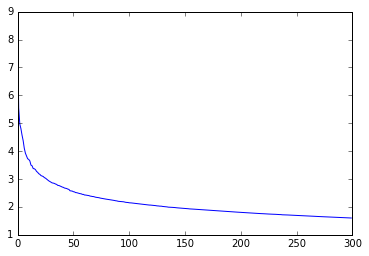

In [38]:
plt.plot(S1[::-1])

Given the low rank structure of `X`, we can write 

     X[n,i] = \sum_k A[n,k] V[k,i]
     
where the sum is over some relatively small number of components.  There are two uses for this representation:
* Word and document embeddings:  A[n,:] provides a low-dimensional vector representation of each document.  This is useful pre-processing step in many natural processing (NLP) methods.  This type of representation is closely related to an important topic of *word embeddings* and *document embeddings*.
* Topic modeling:  One interpretation of the PCA is that each PC `k` represents some common *topic* in the corpus.  Then, `A[n,k] =` the component of topic `k` in document `n` and `V[k,i]` represents the occurance of word `i` in topic `k`.

To get an idea of the words within each PC, we print the words for the largest components in the first 5 PCs.  On a small corpus like 20 newsgroups, the PCs in this case are not very useful.  But, the technique can yield more useful results in larger corpi.

In [41]:
V1sort = np.abs(V1).argsort()[:, ::-1]
for i in range(5):
    print("PC %d:" % i, end='')
    for ind in V1sort[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

PC 0: muenchen does dan bockamp targa colour shall ch uk man
PC 1: phigs government uci 3d khomeini colorado uni rh rayshade screen
PC 2: clarke asimov wesleyan values vga physics fl ed pluto tyre
PC 3: ericsson color wesleyan point program convenient boeing scott targa jpeg
PC 4: thanks muenchen format mac earth pluto color uci true ether
